**Notebook to visualize the categorical trait model probabilistic performance.**

- Fig. S5. Macro-average ROC curve and Precision-Recall curve for the DistilBERT model on the Plants of the World Online (POWO) and Wikipedia (WIKI) datasets.
- Fig. S6. Threshold vs Precision and Recall for the DistilBERT model on the Plants of the World Online (POWO) and Wikipedia (WIKI) datasets.

# Libraries & Functions

In [1]:
'''Math & Data Libraries'''
import numpy as np
import pandas as pd

In [2]:
'''Visualization Libraries'''
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import matplotlib.lines as mlines

sns.set_style("whitegrid", {"grid.color": "0.5", "axes.edgecolor": "0.2"})
color_palette = ["#FF8853", "#FFE174", "#007597", "#C1C36D", "#00A697", "#BC97E0", "#ffc0bf"] #[ "#007597", "#FF8853", "#C1C36D", "#FFE174","#00A697", "#BC97E0", "#ffc0bf"]
sns.set_palette(sns.color_palette(color_palette))

In [3]:
''' Miscellaneous Libraries'''
from tqdm import tqdm
import pickle

In [13]:
''' Machine Learning Libraries'''
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score

In [5]:
trait_values_dict = {}

trait_values_dict["1.2.1"] = ["herb", "shrub", "tree"]
trait_values_dict["1.3.1"] = ["obligatory", "terrestrial"]
trait_values_dict["1.4.1"] = ["obligatory", "self-supporting"]
trait_values_dict["2.1.1"] = ["annual", "perennial"]
trait_values_dict["2.3.1"] = ["phanerophyte", "chamaephyte", "hemicryptophyte", "cryptophyte", "therophyte"]

In [6]:
focus_names = ["Growth Form", "Epiphyte", "Climber", "Lifecycle", "Life Form"]
focus_codes = ["1.2.1", "1.3.1", "1.4.1", "2.1.1", "2.3.1"]
df_names = ["POWO", "WIKI", "POWO_MGH"]

# Result Data

In [7]:
with open("..//Data//Results//Probabilistic_Predictions.pkl", 'rb') as f:
    prediction_probabilities_dict = pickle.load(f)

# Receiver Operating Characteristic Curve (ROC)

In [8]:
fpr_dict, tpr_dict, roc_auc_dict = dict(), dict(), dict()

for focus_name, focus_code in zip(focus_names[:], focus_codes[:]):
    N_classes = len(trait_values_dict[focus_code])
    print("Trait Name:", focus_name)
    for df_name in df_names[:]:
        print("Dataset:", df_name)

        y_pred_proba = prediction_probabilities_dict[df_name, df_name, focus_name]["y_pred_sigmoid"]
        y_true = prediction_probabilities_dict[df_name, df_name, focus_name]["y_true"]
        
        print(y_pred_proba.shape)
        label_binarizer = LabelBinarizer().fit(y_true)
        y_true_onehot = label_binarizer.transform(y_true)
        if(N_classes == 2):
            y_true_onehot = np.hstack((1 - y_true_onehot, y_true_onehot))
        print(y_true_onehot.shape)

        for i in range(N_classes):
            fpr_dict[focus_name, df_name, i], tpr_dict[focus_name, df_name,i], _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
            roc_auc_dict[focus_name, df_name,i] = auc(fpr_dict[focus_name, df_name,i], tpr_dict[focus_name, df_name,i])

        fpr_grid = np.linspace(0.0, 1.0, 1000)

        # Interpolate all ROC curves at these points
        mean_tpr = np.zeros_like(fpr_grid)

        for i in range(N_classes):
            mean_tpr += np.interp(fpr_grid, fpr_dict[focus_name, df_name,i], tpr_dict[focus_name, df_name,i])  # linear interpolation

        # Average it and compute AUC
        mean_tpr /= N_classes

        fpr_dict[focus_name, df_name,"macro"] = fpr_grid
        tpr_dict[focus_name, df_name,"macro"] = mean_tpr
        roc_auc_dict[focus_name, df_name,"macro"] = auc(fpr_dict[focus_name, df_name,"macro"], tpr_dict[focus_name, df_name,"macro"])

        print(f"Macro-averaged One-vs-Rest ROC AUC score for dataset {df_name} and trait {focus_name}:\n{roc_auc_dict[focus_name, df_name,'macro']:.2f}")

Trait Name: Growth Form
Dataset: POWO
(11518, 3)
(11518, 3)
Macro-averaged One-vs-Rest ROC AUC score for dataset POWO and trait Growth Form:
0.98
Dataset: WIKI
(12374, 3)
(12374, 3)
Macro-averaged One-vs-Rest ROC AUC score for dataset WIKI and trait Growth Form:
0.98
Dataset: POWO_MGH
(10950, 3)
(10950, 3)
Macro-averaged One-vs-Rest ROC AUC score for dataset POWO_MGH and trait Growth Form:
0.98
Trait Name: Epiphyte
Dataset: POWO
(11000, 2)
(11000, 2)
Macro-averaged One-vs-Rest ROC AUC score for dataset POWO and trait Epiphyte:
0.98
Dataset: WIKI
(11168, 2)
(11168, 2)
Macro-averaged One-vs-Rest ROC AUC score for dataset WIKI and trait Epiphyte:
1.00
Dataset: POWO_MGH
(10297, 2)
(10297, 2)
Macro-averaged One-vs-Rest ROC AUC score for dataset POWO_MGH and trait Epiphyte:
0.98
Trait Name: Climber
Dataset: POWO
(11371, 2)
(11371, 2)
Macro-averaged One-vs-Rest ROC AUC score for dataset POWO and trait Climber:
0.98
Dataset: WIKI
(12606, 2)
(12606, 2)
Macro-averaged One-vs-Rest ROC AUC score f

# Precision-Recall Curve

In [9]:
precision_dict, recall_dict, average_precision_dict = dict(), dict(), dict()
threshold_pr_dict = dict()
for focus_name, focus_code in zip(focus_names[:], focus_codes[:]):
    N_classes = len(trait_values_dict[focus_code])

    for df_name in df_names[:2]:

        y_pred_proba = prediction_probabilities_dict[df_name, df_name, focus_name]["y_pred_sigmoid"]
        y_true = prediction_probabilities_dict[df_name, df_name, focus_name]["y_true"]
        
        print(y_pred_proba.shape)
        label_binarizer = LabelBinarizer().fit(y_true)
        y_true_onehot = label_binarizer.transform(y_true)
        if(N_classes == 2):
            y_true_onehot = np.hstack((1 - y_true_onehot, y_true_onehot))
            
        for i in range(N_classes):
            precision_dict[focus_name, df_name, i], recall_dict[focus_name, df_name,i], threshold_pr_dict[focus_name, df_name,i] = precision_recall_curve(y_true_onehot[:, i], y_pred_proba[:, i])
            average_precision_dict[focus_name, df_name,i] = average_precision_score(y_true_onehot[:, i], y_pred_proba[:, i])

        pr_grid = np.linspace(0.0, 1.0, 100)

        
        # Interpolate all ROC curves at these points
        mean_recall = np.zeros_like(pr_grid)
        macro_precision = 0
        
        for i in range(N_classes):
            mean_recall += np.interp(pr_grid, precision_dict[focus_name, df_name,i], recall_dict[focus_name, df_name,i])/N_classes  # linear interpolation
            macro_precision += average_precision_dict[focus_name, df_name,i]/N_classes
            
        precision_dict[focus_name, df_name,"macro"] = pr_grid
        recall_dict[focus_name, df_name,"macro"] = mean_recall
        average_precision_dict[focus_name, df_name,"macro"] = macro_precision

        print(f"Macro-averaged Precision score for dataset {df_name} and trait {focus_name}:\n{average_precision_dict[focus_name, df_name,'macro']:.2f}")

(11518, 3)
Macro-averaged Precision score for dataset POWO and trait Growth Form:
0.92
(12374, 3)
Macro-averaged Precision score for dataset WIKI and trait Growth Form:
0.96
(11000, 2)
Macro-averaged Precision score for dataset POWO and trait Epiphyte:
0.95
(11168, 2)
Macro-averaged Precision score for dataset WIKI and trait Epiphyte:
0.99
(11371, 2)
Macro-averaged Precision score for dataset POWO and trait Climber:
0.94
(12606, 2)
Macro-averaged Precision score for dataset WIKI and trait Climber:
0.90
(9084, 2)
Macro-averaged Precision score for dataset POWO and trait Lifecycle:
0.93
(11101, 2)
Macro-averaged Precision score for dataset WIKI and trait Lifecycle:
0.95
(5350, 5)
Macro-averaged Precision score for dataset POWO and trait Life Form:
0.88
(6262, 5)
Macro-averaged Precision score for dataset WIKI and trait Life Form:
0.86


C:\Users\Admin\AppData\Local\Temp\ipykernel_151908\3580860791.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
C:\Users\Admin\AppData\Local\Temp\ipykernel_151908\3580860791.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
C:\Users\Admin\AppData\Local\Temp\ipykernel_151908\3580860791.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
C:\Users\Admin\AppData\Local\Temp\ipykernel_151908\3580860791.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)


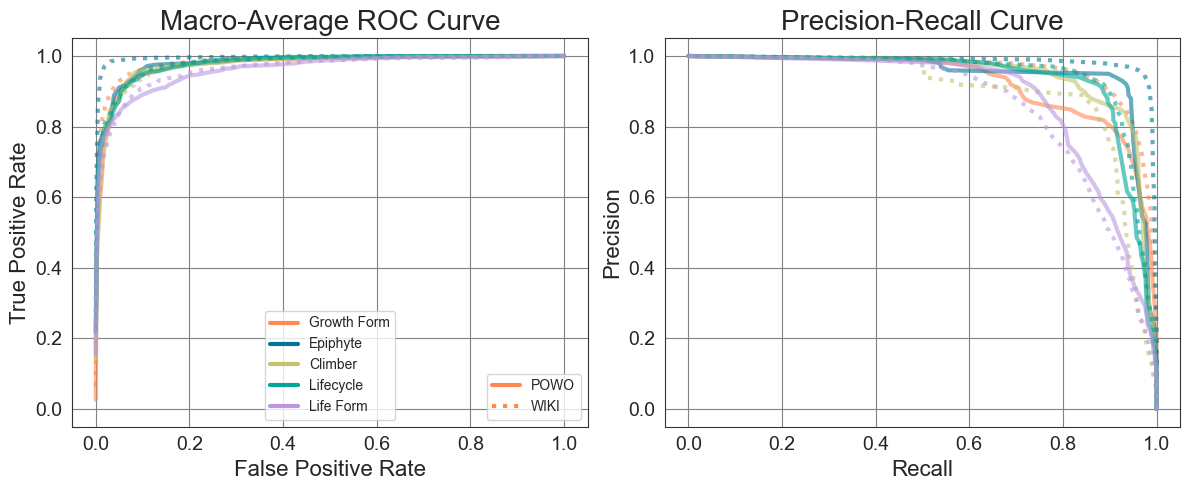

In [10]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

palette = color_palette[0:1] + color_palette[2:] + color_palette[:1]

plt.subplot(121)
for i, (focus_name, focus_code) in enumerate(zip(focus_names[:], focus_codes[:])):
    N_classes = len(trait_values_dict[focus_code])

    plt.plot(
        fpr_dict[focus_name, "POWO", "macro"],
        tpr_dict[focus_name, "POWO","macro"],
        # label=f"{focus_name} Precision Curve",
        linestyle="-",
        linewidth=3,
        alpha=0.6,
        color = palette[i]
    )

    plt.plot(
        fpr_dict[focus_name, "WIKI", "macro"],
        tpr_dict[focus_name, "WIKI","macro"],
        # label=f"{focus_name} Precision Curve",
        linestyle=":",
        linewidth=3,
        alpha=0.6,
        color = palette[i]
    )
    

plt.xlabel("False Positive Rate", size = 16)
plt.ylabel("True Positive Rate", size = 16)
ax[0].set_xticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
ax[0].set_yticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

traits = [mlines.Line2D([], [], color=palette[i], marker='', ls='-', linewidth = 3, label=focus_name) for i, focus_name in enumerate(focus_names)]
plt.legend(handles=traits)

datasets = [mlines.Line2D([], [], color=palette[0], marker='', ls='-', linewidth = 3, label="POWO"), mlines.Line2D([], [], color=palette[0], marker='', ls=':', linewidth = 3, label="WIKI")]

legend1 = plt.legend(handles = datasets, loc = 0)
plt.legend(handles=traits, loc = 8)
plt.gca().add_artist(legend1)
# plt.axis("square")
plt.title("Macro-Average ROC Curve", size = 20)

plt.subplot(122)
for i, (focus_name, focus_code) in enumerate(zip(focus_names[:], focus_codes[:])):
    N_classes = len(trait_values_dict[focus_code])

    plt.plot(
        recall_dict[focus_name, "POWO", "macro"],
        precision_dict[focus_name, "POWO","macro"],
        # label=f"{focus_name} Precision Curve",
        linestyle="-",
        linewidth=3,
        alpha=0.6,
        color = palette[i]
    )

    plt.plot(
        recall_dict[focus_name, "WIKI", "macro"],
        precision_dict[focus_name, "WIKI","macro"],
        # label=f"{focus_name} Precision Curve",
        linestyle=":",
        linewidth=3,
        alpha=0.6,
        color = palette[i]
    )
    

plt.xlabel("Recall", size = 16)
plt.ylabel("Precision", size = 16)
ax[1].set_xticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
ax[1].set_yticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

traits = [mlines.Line2D([], [], color=palette[i], marker='', ls='-', linewidth = 3, label=focus_name) for i, focus_name in enumerate(focus_names)]
# plt.legend(handles=traits, framealpha = 1)

datasets = [mlines.Line2D([], [], color=palette[0], marker='', ls='-', linewidth = 3, label="POWO"), mlines.Line2D([], [], color=palette[0], marker='', ls=':', linewidth = 3, label="WIKI")]

# legend1 = plt.legend(handles = datasets, loc = 0)
# plt.legend(handles=traits, loc = 8, framealpha = 0.95)
# plt.gca().add_artist(legend1)
# plt.axis("square")
plt.title("Precision-Recall Curve", size = 20)

plt.tight_layout()
plt.show()

# Threshold Rate vs Precision/Recall

In [11]:
precision_threshold_score, recall_threshold_score = dict(), dict()
threshold_score = np.linspace(0.0, 1.0, 1000)

for focus_name, focus_code in zip(focus_names[:], focus_codes[:]):
    N_classes = len(trait_values_dict[focus_code])

    for df_name in df_names[:2]:

        y_pred_proba = prediction_probabilities_dict[df_name, df_name, focus_name]["y_pred_sigmoid"]
        y_true = prediction_probabilities_dict[df_name, df_name, focus_name]["y_true"]
        
        print(y_pred_proba.shape)
        label_binarizer = LabelBinarizer().fit(y_true)
        y_true_onehot = label_binarizer.transform(y_true)
        if(N_classes == 2):
            y_true_onehot = np.hstack((1 - y_true_onehot, y_true_onehot))
            
        for i in range(N_classes):
            
            tmp_list_precision = []
            tmp_list_recall = []

            for t in np.linspace(0.0, 1.0, 1000):
                y_pred_class = np.where(y_pred_proba[:, i]>t, 1, 0)
                y_test_class = y_true_onehot[:, i]
                tmp_list_precision.append(precision_score(y_test_class, y_pred_class, zero_division=0))
                tmp_list_recall.append(recall_score(y_test_class, y_pred_class))
    
            precision_threshold_score[focus_name, df_name, i] = np.array(tmp_list_precision)
            recall_threshold_score[focus_name, df_name, i] = np.array(tmp_list_recall)

        precision_threshold_score[focus_name, df_name, "macro"] = np.zeros(threshold_score.shape)
        recall_threshold_score[focus_name, df_name, "macro"] = np.zeros(threshold_score.shape)

        for i in range(N_classes):
            precision_threshold_score[focus_name, df_name, "macro"] += precision_threshold_score[focus_name, df_name, i]/N_classes 
            recall_threshold_score[focus_name, df_name, "macro"] += recall_threshold_score[focus_name, df_name, i]/N_classes

(11518, 3)
(12374, 3)
(11000, 2)
(11168, 2)
(11371, 2)
(12606, 2)
(9084, 2)
(11101, 2)
(5350, 5)
(6262, 5)


C:\Users\Admin\AppData\Local\Temp\ipykernel_151908\98022994.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
C:\Users\Admin\AppData\Local\Temp\ipykernel_151908\98022994.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
C:\Users\Admin\AppData\Local\Temp\ipykernel_151908\98022994.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
C:\Users\Admin\AppData\Local\Temp\ipykernel_151908\98022994.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)


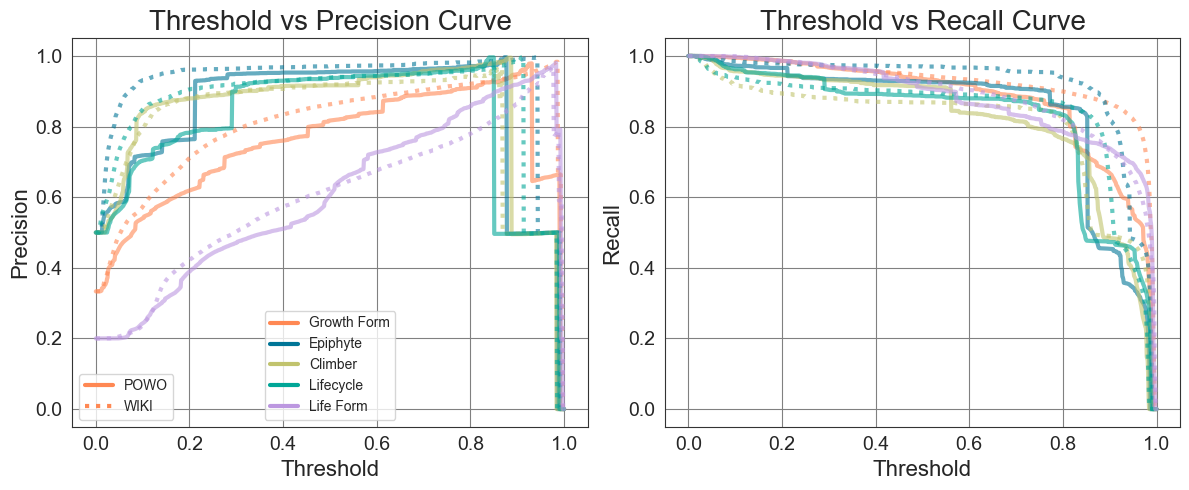

In [12]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)
i = 0
palette = color_palette[0:1] + color_palette[2:] + color_palette[:1]

for focus_name, focus_code in zip(focus_names[:], focus_codes[:]):
    N_classes = len(trait_values_dict[focus_code])

    plt.subplot(1,2,1)
    plt.plot(
        threshold_score,
        precision_threshold_score[focus_name, "POWO", "macro"],
        label=f"{focus_name} Precision Curve",
        linestyle="-",
        linewidth=3,
        alpha=0.6,
        color = palette[i]
    )

    plt.plot(
        threshold_score,
        precision_threshold_score[focus_name, "WIKI", "macro"],
        label=f"{focus_name} Precision Curve",
        linestyle=":",
        linewidth=3,
        alpha=0.6,
        color = palette[i]
    )

    plt.title("Threshold vs Precision Curve", fontsize = 20)
    
    plt.subplot(1,2,2)
    plt.plot(
        threshold_score,
        recall_threshold_score[focus_name, "POWO", "macro"],
        label=f"{focus_name} Recall Curve",
        linestyle="-",
        linewidth=3,
        alpha=0.6,
        color = palette[i]
    )

    plt.plot(
        threshold_score,
        recall_threshold_score[focus_name, "WIKI", "macro"],
        label=f"{focus_name} Recall Curve",
        linestyle=":",
        linewidth=3,
        alpha=0.6,
        color = palette[i]
    )
    plt.title("Threshold vs Recall Curve", fontsize = 20)

    i+=1 
    
plt.subplot(1,2,1)
plt.xlabel("Threshold", size = 16)
plt.ylabel("Precision", size = 16)
ax[0].set_xticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
ax[0].set_yticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

traits = [mlines.Line2D([], [], color=palette[i], marker='', ls='-', linewidth = 3, label=focus_name) for i, focus_name in enumerate(focus_names)]
plt.legend(handles=traits)

datasets = [mlines.Line2D([], [], color=palette[0], marker='', ls='-', linewidth = 3, label="POWO"), mlines.Line2D([], [], color=palette[0], marker='', ls=':', linewidth = 3, label="WIKI")]

legend1 = plt.legend(handles = datasets, loc = 0)
plt.legend(handles=traits, loc = 8)
plt.gca().add_artist(legend1)

plt.subplot(1,2,2)
plt.xlabel("Threshold", size = 16)
plt.ylabel("Recall", size = 16)
ax[1].set_xticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
ax[1].set_yticklabels(np.round(np.arange(0, 1.3, 0.2)-0.2, 1), size=14)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05,)
plt.tight_layout()

# plt.savefig("Figures/Threshold_Precision_Recall_Curves.png", dpi=600, bbox_inches='tight')
plt.show()

# Evaluate Models with Threshold Predictions

In [14]:
df_results = pd.DataFrame()

for focus_name, focus_code in zip(focus_names[:], focus_codes[:]):
    for dataset in df_names[:]:
        tmp_list = []

        y_predict = np.argmax(prediction_probabilities_dict[dataset, dataset, focus_name]["y_pred_sigmoid"], axis=1)
        y_test = prediction_probabilities_dict[dataset, dataset, focus_name]["y_true"]

        acc_gift = accuracy_score(y_test, y_predict)
        prec_gift = precision_score(y_test, y_predict, average = "macro")
        rec_gift = recall_score(y_test, y_predict, average = "macro")
        f1_gift = f1_score(y_test, y_predict, average = "macro")

        results = [acc_gift, prec_gift, rec_gift, f1_gift]
        tmp_list.append([dataset, dataset, focus_name, focus_name] + results + [f"DistilBERT ArgMAX", "Embedding"])

        for i, trait_value in enumerate(trait_values_dict[focus_code]):
            y_predict_class = np.zeros(y_predict.shape)
            y_predict_class[y_predict==i] = 1

            y_test_class = np.zeros(y_predict.shape)
            y_test_class[y_test==i] = 1

            acc_gift = accuracy_score(y_test_class, y_predict_class)
            prec_gift = precision_score(y_test_class, y_predict_class)
            rec_gift = recall_score(y_test_class, y_predict_class)
            f1_gift = f1_score(y_test_class, y_predict_class)

            results = [acc_gift, prec_gift, rec_gift, f1_gift]

            tmp_list.append([dataset, dataset, focus_name, trait_value] + results + [f"DistilBERT ArgMAX", "Embedding"])

        df_results_class = pd.DataFrame(tmp_list, columns=["Train Dataset", "Test Dataset", "Trait", "Trait Value", "Accuracy", "Precision", "Recall", "F1-Score", "Model", "Representation"])
        df_results = pd.concat([df_results, df_results_class])
df_results

,Train Dataset,Test Dataset,Trait,Trait Value,Accuracy,Precision,Recall,F1-Score,Model,Representation
0,POWO,POWO,Growth Form,Growth Form,0.920820,0.891916,0.888477,0.890032,DistilBERT ArgMAX,Embedding
1,POWO,POWO,Growth Form,herb,0.953030,0.956534,0.964527,0.960514,DistilBERT ArgMAX,Embedding
2,POWO,POWO,Growth Form,shrub,0.925682,0.781959,0.800494,0.791118,DistilBERT ArgMAX,Embedding
3,POWO,POWO,Growth Form,tree,0.962928,0.937256,0.900412,0.918465,DistilBERT ArgMAX,Embedding
0,WIKI,WIKI,Growth Form,Growth Form,0.925893,0.911443,0.909723,0.910574,DistilBERT ArgMAX,Embedding
1,WIKI,WIKI,Growth Form,herb,0.957411,0.953931,0.960026,0.956969,DistilBERT ArgMAX,Embedding
2,WIKI,WIKI,Growth Form,shrub,0.932197,0.842004,0.835884,0.838933,DistilBERT ArgMAX,Embedding
3,WIKI,WIKI,Growth Form,tree,0.962179,0.938394,0.933260,0.935820,DistilBERT ArgMAX,Embedding
0,POWO_MGH,POWO_MGH,Growth Form,Growth Form,0.928584,0.901012,0.903459,0.901743,DistilBERT ArgMAX,Embedding
1,POWO_MGH,POWO_MGH,Growth Form,herb,0.958630,0.965055,0.964302,0.964678,DistilBERT ArgMAX,Embedding


In [15]:
df_results.shape

(57, 10)

In [16]:
for t in [0.5, 0.8]:
    for focus_name, focus_code in zip(focus_names[:], focus_codes[:]):
        for dataset in df_names[:]:
            tmp_list = []

            for i, trait_value in enumerate(trait_values_dict[focus_code]):
                y_predict_class = np.where(prediction_probabilities_dict[dataset, dataset, focus_name]["y_pred_sigmoid"][:,i]>=t, 1, 0)

                y_test_class = np.zeros(y_predict_class.shape) #regex_test[focus_code, focus_name]
                y_test_class[prediction_probabilities_dict[dataset, dataset, focus_name]["y_true"]==i] = 1

                acc_gift = accuracy_score(y_test_class, y_predict_class)
                prec_gift = precision_score(y_test_class, y_predict_class)
                rec_gift = recall_score(y_test_class, y_predict_class)
                f1_gift = f1_score(y_test_class, y_predict_class)

                results = [acc_gift, prec_gift, rec_gift, f1_gift]

                tmp_list.append([dataset, dataset, focus_name, trait_value] + results + [f"DistilBERT t={t}", "Embedding"])

            tmp_list.append([dataset, dataset, focus_name, focus_name] + list(np.mean(np.array(tmp_list)[:, 4:8].astype(float), axis=0)) + [f"DistilBERT t={t}", "Embedding"])

            df_results_class = pd.DataFrame(tmp_list, columns=["Train Dataset", "Test Dataset", "Trait", "Trait Value", "Accuracy", "Precision", "Recall", "F1-Score", "Model", "Representation"])
            df_results = pd.concat([df_results, df_results_class])
df_results

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Train Dataset,Test Dataset,Trait,Trait Value,Accuracy,Precision,Recall,F1-Score,Model,Representation
0,POWO,POWO,Growth Form,Growth Form,0.920820,0.891916,0.888477,0.890032,DistilBERT ArgMAX,Embedding
1,POWO,POWO,Growth Form,herb,0.953030,0.956534,0.964527,0.960514,DistilBERT ArgMAX,Embedding
2,POWO,POWO,Growth Form,shrub,0.925682,0.781959,0.800494,0.791118,DistilBERT ArgMAX,Embedding
3,POWO,POWO,Growth Form,tree,0.962928,0.937256,0.900412,0.918465,DistilBERT ArgMAX,Embedding
0,WIKI,WIKI,Growth Form,Growth Form,0.925893,0.911443,0.909723,0.910574,DistilBERT ArgMAX,Embedding
...,...,...,...,...,...,...,...,...,...,...
1,POWO_MGH,POWO_MGH,Life Form,chamaephyte,0.947044,0.658824,0.495575,0.565657,DistilBERT t=0.8,Embedding
2,POWO_MGH,POWO_MGH,Life Form,hemicryptophyte,0.901888,0.855314,0.875783,0.865428,DistilBERT t=0.8,Embedding
3,POWO_MGH,POWO_MGH,Life Form,cryptophyte,0.954433,0.787500,0.620690,0.694215,DistilBERT t=0.8,Embedding
4,POWO_MGH,POWO_MGH,Life Form,therophyte,0.950123,0.928814,0.820359,0.871224,DistilBERT t=0.8,Embedding


C:\Users\Admin\AppData\Local\Temp\ipykernel_151908\1047852917.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.round(np.arange(0, 1.2, 0.2), 1), size=18)


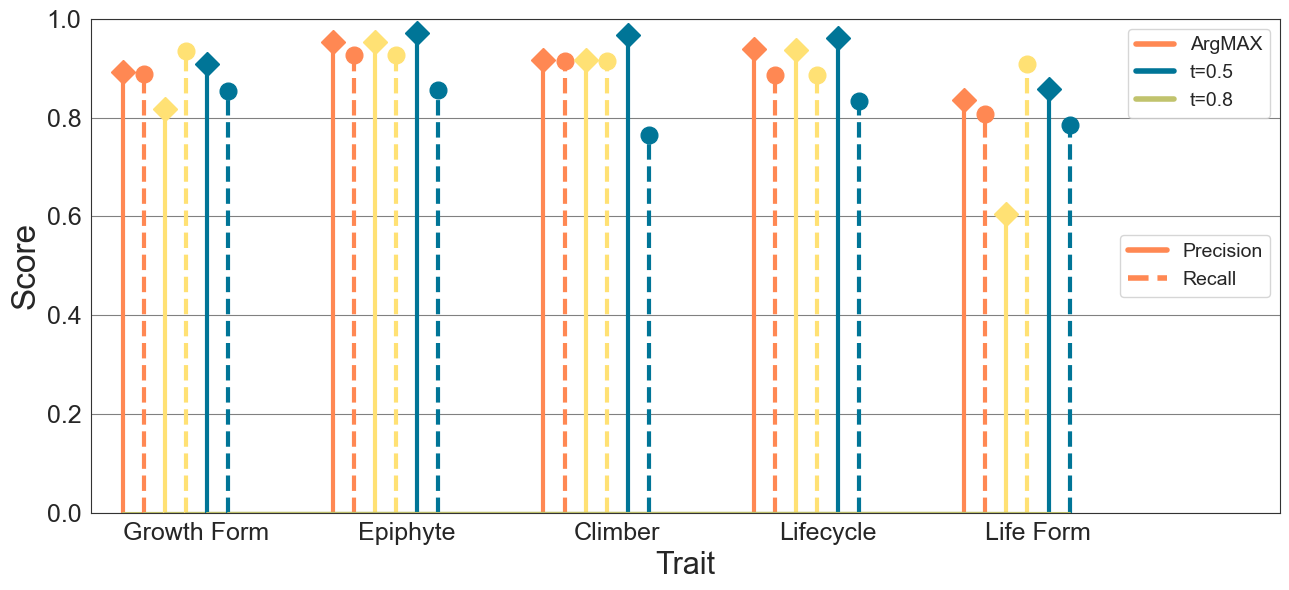

C:\Users\Admin\AppData\Local\Temp\ipykernel_151908\1047852917.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.round(np.arange(0, 1.2, 0.2), 1), size=18)


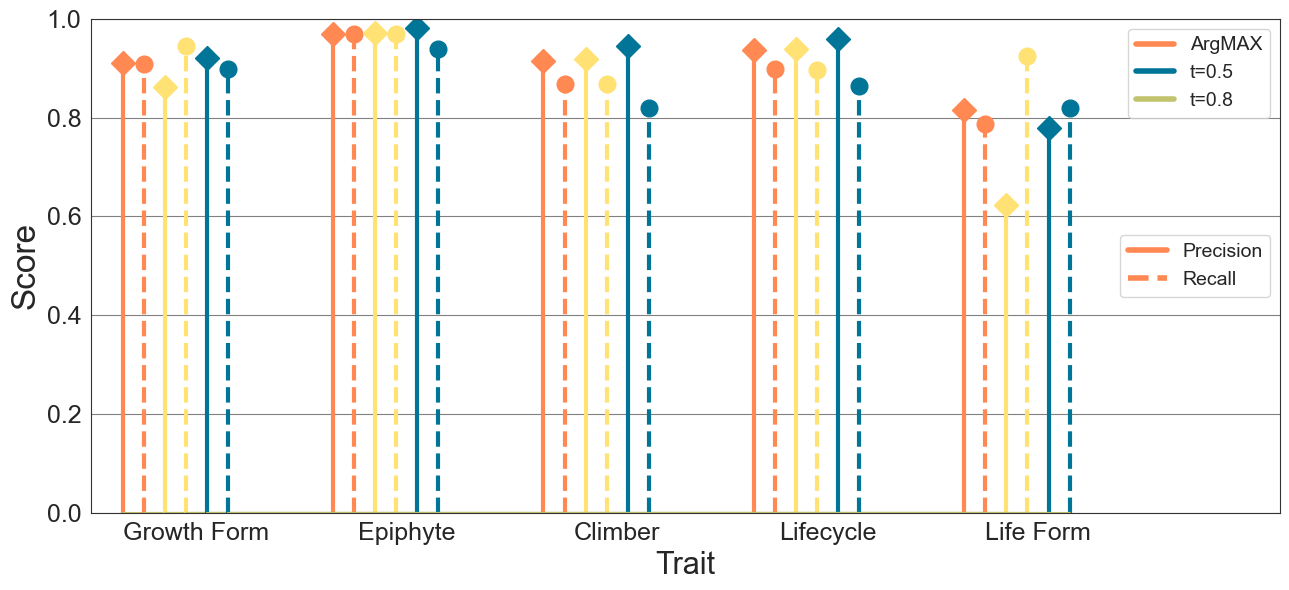

In [44]:
for i, dataset in enumerate(["POWO", "WIKI"]):#, "Recall"]):

    fig, axes  = plt.subplots(figsize=(13,6), nrows = 1)
    start = 0
    for j, model in enumerate(["DistilBERT ArgMAX", "DistilBERT t=0.5", "DistilBERT t=0.8"]):
        for k, metric in enumerate(["Precision", "Recall"]):
            df_subset = df_results[(df_results["Model"]==model)*(df_results["Train Dataset"]==dataset)*(df_results["Test Dataset"]==dataset)*df_results["Trait Value"].apply(lambda x: x in focus_names)]
            if(metric=="Precision"):
                (markers, stemlines, baseline) = plt.stem(start + np.arange(len(df_subset))*10, df_subset[metric])
                plt.setp(markers, marker='D', markersize=12, color = color_palette[j])
                plt.setp(stemlines, linewidth=3, color = color_palette[j])
                    
            if(metric=="Recall"):
                (markers, stemlines, baseline) = plt.stem(start + 1 + np.arange(len(df_subset))*10, df_subset[metric])
                plt.setp(markers, marker='o', markersize=12, color = color_palette[j])
                plt.setp(stemlines, linewidth=3, linestyle = "--", color = color_palette[j])
                start += 2
    
    axes.set_xticks(np.arange(3.5, 45, 10))
    axes.set_xticklabels(["Growth Form", "Epiphyte", "Climber", "Lifecycle", "Life Form"], size=18, rotation="horizontal")
    axes.set_yticklabels(np.round(np.arange(0, 1.2, 0.2), 1), size=18)
    axes.grid(axis='x')
    plt.xlabel("Trait", size = 22)
    plt.ylabel("Score", size = 24)
    plt.ylim(0, 1)
    plt.xlim(-1.5, 55)

    thresholds = [mlines.Line2D([], [], color=palette[i], marker='', ls='-', linewidth = 4, label=threshold) for i, threshold in enumerate(["ArgMAX", "t=0.5", "t=0.8"])]
    metrics = [mlines.Line2D([], [], color=palette[0], marker='', ls='-', linewidth = 4, label="Precision"), mlines.Line2D([], [], color=palette[0], marker='', ls='--', linewidth = 4, label="Recall")]
    legend1 = plt.legend(handles = metrics, loc = "center right", fontsize = 14)
    plt.legend(handles=thresholds, loc = "upper right", fontsize = 14)
    plt.gca().add_artist(legend1)
    plt.tight_layout()
    plt.show()